# Perceptrón Simple: Implementación desde Cero con NumPy

**Materiales desarrollados por Matías Barreto, 2025**

**Tecnicatura en Ciencia de Datos - IFTS**

**Asignatura:** Procesamiento de Lenguaje Natural

---

## Introducción

En este notebook vamos a construir desde cero, usando únicamente NumPy, el modelo más fundamental de las redes neuronales: el **Perceptrón Simple**. Inventado por Frank Rosenblatt en 1958, el perceptrón fue la primera implementación de una neurona artificial y sentó las bases para toda la inteligencia artificial moderna.

### ¿Por qué implementarlo desde cero?

Antes de usar frameworks como PyTorch o TensorFlow, es fundamental entender **qué está pasando bajo el capó**:

1. **Desmitificar el deep learning**: Una neurona es solo multiplicaciones, sumas y una función no lineal
2. **Debugging conceptual**: Cuando algo falle en PyTorch, vas a entender el por qué
3. **Intuición sobre backpropagation**: La regla de actualización del perceptrón es la versión más simple de descenso de gradiente
4. **Apreciación de frameworks**: Después de programar 50 líneas para un perceptrón, vas a valorar `model.fit()`

### Objetivos de aprendizaje

1. Comprender la arquitectura de una neurona artificial
2. Implementar la función de activación escalón
3. Programar la regla de aprendizaje del perceptrón
4. Entrenar el modelo ajustando pesos manualmente
5. Entender las limitaciones de modelos linealmente separables
6. Preparar el camino conceptual para redes multicapa

### Contexto histórico

**1958**: Frank Rosenblatt presenta el perceptrón en Cornell
**1969**: Minsky y Papert publican "Perceptrons", mostrando sus limitaciones (no puede resolver XOR)
**1986**: Rumelhart, Hinton y Williams popularizarán backpropagation para redes multicapa
**Hoy**: El perceptrón es el building block de redes con millones de parámetros

---

## 1. Importación de Librerías

Solo necesitamos NumPy para operaciones numéricas. No vamos a usar scikit-learn ni ningún framework de ML.

In [1]:
# NumPy: Para arrays y operaciones numéricas
import numpy as np

# Matplotlib: Para visualización (opcional)
import matplotlib.pyplot as plt

# Fijamos semilla para reproducibilidad
# Esto garantiza que los pesos aleatorios iniciales sean siempre los mismos
np.random.seed(42)

print("Librerías importadas correctamente.")
print(f"NumPy versión: {np.__version__}")

Librerías importadas correctamente.
NumPy versión: 2.0.2


---

## 2. Dataset: Análisis de Sentimiento en Español Rioplatense

Vamos a trabajar con un conjunto pequeño de frases etiquetadas. Usamos vocabulario coloquial argentino para que sea cercano y realista.

In [2]:
# Corpus de frases con sentimiento etiquetado
# 1 = Positivo, 0 = Negativo
frases = [
    "Amo el verano en Buenos Aires",
    "No me gusta el tráfico matutino",
    "Este asado está espectacular",
    "Qué bajón, perdí el colectivo",
    "Me encanta salir los domingos",
    "Detesto el calor húmedo"
]

# Etiquetas: 1 = sentimiento positivo, 0 = sentimiento negativo
etiquetas = np.array([1, 0, 1, 0, 1, 0])

print("Corpus de entrenamiento:")
print("=" * 70)
for i, (frase, etiq) in enumerate(zip(frases, etiquetas), 1):
    sentimiento = "POSITIVO" if etiq == 1 else "NEGATIVO"
    print(f"{i}. [{sentimiento}] {frase}")

print(f"\nTotal de frases: {len(frases)}")
print(f"Distribución: {np.bincount(etiquetas)} (negativas, positivas)")

Corpus de entrenamiento:
1. [POSITIVO] Amo el verano en Buenos Aires
2. [NEGATIVO] No me gusta el tráfico matutino
3. [POSITIVO] Este asado está espectacular
4. [NEGATIVO] Qué bajón, perdí el colectivo
5. [POSITIVO] Me encanta salir los domingos
6. [NEGATIVO] Detesto el calor húmedo

Total de frases: 6
Distribución: [3 3] (negativas, positivas)


---

## 3. Construcción del Vocabulario

Definimos manualmente un vocabulario de palabras clave con carga emocional. En un sistema real, esto se construiría automáticamente, pero aquí lo hacemos explícito para fines didácticos.

In [3]:
# Vocabulario: palabras con carga emocional
# Elegimos palabras que aparecen en las frases y que tienen connotación clara
vocabulario = [
    "amo",           # Positiva
    "no",            # Negativa (negación)
    "gusta",         # Positiva
    "asado",         # Positiva (cultural argentino)
    "espectacular",  # Positiva
    "bajón",         # Negativa (jerga argentina)
    "perdí",         # Negativa
    "encanta",       # Positiva
    "detesto",       # Negativa
    "calor"          # Neutral/contexto
]

print(f"Vocabulario construido con {len(vocabulario)} palabras:")
print(vocabulario)

print("\nNota: Este vocabulario es pequeño y manual por fines pedagógicos.")
print("En un sistema real, usaríamos TF-IDF o embeddings pre-entrenados.")

Vocabulario construido con 10 palabras:
['amo', 'no', 'gusta', 'asado', 'espectacular', 'bajón', 'perdí', 'encanta', 'detesto', 'calor']

Nota: Este vocabulario es pequeño y manual por fines pedagógicos.
En un sistema real, usaríamos TF-IDF o embeddings pre-entrenados.


---

## 4. Vectorización: De Texto a Números

Convertimos cada frase en un **vector binario** de longitud igual al vocabulario:
- `1` si la palabra aparece en la frase
- `0` si no aparece

Esto se conoce como **Bag of Words binario** (ignora frecuencia, solo presencia/ausencia).

In [4]:
def vectorizar(frase, vocabulario):
    """
    Convierte una frase en un vector binario según el vocabulario.

    Args:
        frase (str): La frase a vectorizar
        vocabulario (list): Lista de palabras del vocabulario

    Returns:
        np.array: Vector binario de longitud len(vocabulario)

    Ejemplo:
        frase = "Me gusta el asado"
        vocabulario = ["gusta", "asado", "detesto"]
        vectorizar(frase, vocabulario) -> [1, 1, 0]
    """
    # Tokenización simple: split por espacios y convertir a minúsculas
    tokens = frase.lower().split()

    # Crear vector: 1 si palabra está en tokens, 0 si no
    vector = np.array([1 if palabra in tokens else 0 for palabra in vocabulario])

    return vector


# Aplicamos la vectorización a todas las frases
X = np.array([vectorizar(frase, vocabulario) for frase in frases])

print("Matriz de características (X):")
print("=" * 70)
print(f"Forma: {X.shape} (filas = frases, columnas = palabras del vocabulario)")
print("\nPrimeras 3 filas:")
print(X[:3])

print("\nInterpretación:")
print(f"Frase 1: '{frases[0]}'")
print(f"Vector: {X[0]}")
print(f"Palabras presentes: {[vocabulario[i] for i in range(len(vocabulario)) if X[0][i] == 1]}")

Matriz de características (X):
Forma: (6, 10) (filas = frases, columnas = palabras del vocabulario)

Primeras 3 filas:
[[1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]]

Interpretación:
Frase 1: 'Amo el verano en Buenos Aires'
Vector: [1 0 0 0 0 0 0 0 0 0]
Palabras presentes: ['amo']


---

## 5. Arquitectura del Perceptrón

Un perceptrón es una neurona artificial que realiza una clasificación binaria. Su arquitectura consta de:

### Componentes:

1. **Vector de entrada (x)**: Las features (en nuestro caso, el vector de palabras)
2. **Pesos sinápticos (w)**: Un peso por cada feature, determina la importancia
3. **Bias (b)**: Un término constante (sesgo)
4. **Suma ponderada (z)**: z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b
5. **Función de activación (σ)**: Transforma z en una predicción

### Fórmula matemática:

$$y = \sigma(\sum_{i=1}^{n} w_i x_i + b)$$

Donde:
- $x_i$: Feature i
- $w_i$: Peso de la feature i
- $b$: Bias
- $\sigma$: Función de activación escalón

### Función de activación escalón:

$$
\sigma(z) =
\begin{cases}
1 & \text{si } z > 0 \\
0 & \text{si } z \leq 0
\end{cases}
$$

### Visualización:

```
x₁ ──w₁──┐
x₂ ──w₂──┤
x₃ ──w₃──├──> Σ + b ──> σ(z) ──> y (0 o 1)
   ...   │
xₙ ──wₙ──┘
```

In [5]:
# Inicializamos los parámetros del perceptrón

# Dimensión del vector de entrada (número de palabras en el vocabulario)
n_features = len(vocabulario)

# Pesos sinápticos: uno por cada feature
# Inicialización aleatoria desde una distribución normal
# randn() genera números con media 0 y desviación estándar 1
pesos = np.random.randn(n_features)

# Bias (sesgo): inicializado en 0
bias = 0.0

print("Parámetros del perceptrón inicializados:")
print("=" * 70)
print(f"Número de features: {n_features}")
print(f"\nPesos iniciales (aleatorios):")
for i, palabra in enumerate(vocabulario):
    print(f"  w[{palabra}] = {pesos[i]:.4f}")
print(f"\nBias inicial: {bias}")

print("\nNota: Los pesos aleatorios se ajustarán durante el entrenamiento.")

Parámetros del perceptrón inicializados:
Número de features: 10

Pesos iniciales (aleatorios):
  w[amo] = 0.4967
  w[no] = -0.1383
  w[gusta] = 0.6477
  w[asado] = 1.5230
  w[espectacular] = -0.2342
  w[bajón] = -0.2341
  w[perdí] = 1.5792
  w[encanta] = 0.7674
  w[detesto] = -0.4695
  w[calor] = 0.5426

Bias inicial: 0.0

Nota: Los pesos aleatorios se ajustarán durante el entrenamiento.


---

## 6. Función de Activación: Escalón

La función escalón (step function) es la más simple de las funciones de activación:
- Retorna `1` si la entrada es positiva
- Retorna `0` si la entrada es negativa o cero

**Limitación importante**: No es diferenciable en z=0, por lo que no se puede usar con backpropagation. Por eso las redes modernas usan ReLU, sigmoid o tanh.

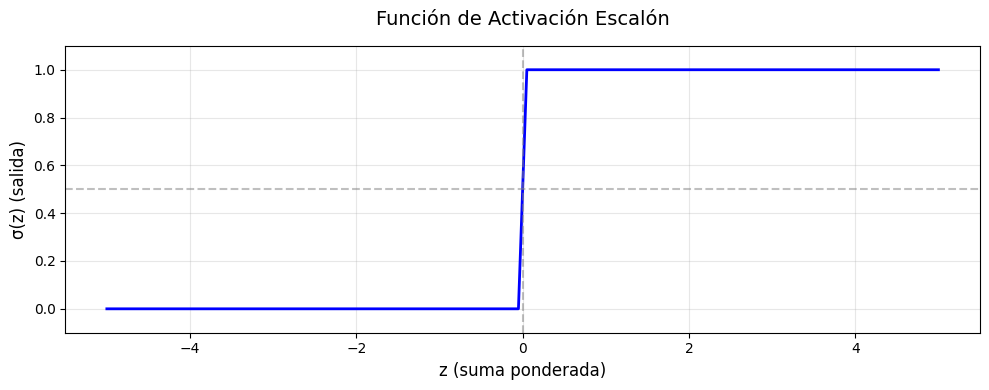

Características de la función escalón:
- Discontinua en z=0
- No diferenciable (derivada no definida en z=0)
- Salida binaria: solo 0 o 1
- Históricamente importante pero ya no se usa en deep learning moderno


In [6]:
def activacion_escalon(z):
    """
    Función de activación escalón (step function).

    Args:
        z (float): Suma ponderada de entradas

    Returns:
        int: 1 si z > 0, sino 0
    """
    return 1 if z > 0 else 0


# Visualización de la función escalón
z_values = np.linspace(-5, 5, 100)
activaciones = [activacion_escalon(z) for z in z_values]

plt.figure(figsize=(10, 4))
plt.plot(z_values, activaciones, linewidth=2, color='blue')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('z (suma ponderada)', fontsize=12)
plt.ylabel('σ(z) (salida)', fontsize=12)
plt.title('Función de Activación Escalón', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

print("Características de la función escalón:")
print("- Discontinua en z=0")
print("- No diferenciable (derivada no definida en z=0)")
print("- Salida binaria: solo 0 o 1")
print("- Históricamente importante pero ya no se usa en deep learning moderno")

---

## 7. Función de Predicción

Implementamos la función forward (propagación hacia adelante) del perceptrón.

In [7]:
def predecir(x, pesos, bias):
    """
    Realiza una predicción con el perceptrón.

    Args:
        x (np.array): Vector de entrada (features)
        pesos (np.array): Vector de pesos
        bias (float): Término de sesgo

    Returns:
        int: Predicción (0 o 1)

    Proceso:
        1. Calcular suma ponderada: z = w·x + b
        2. Aplicar función de activación: y = σ(z)
    """
    # Producto punto: suma de productos elemento a elemento
    # np.dot(w, x) = w₁x₁ + w₂x₂ + ... + wₙxₙ
    z = np.dot(pesos, x) + bias

    # Aplicamos la función de activación
    y_pred = activacion_escalon(z)

    return y_pred


# Probamos la función de predicción con una frase de ejemplo
print("Prueba de predicción con pesos aleatorios (antes del entrenamiento):")
print("=" * 70)

frase_test = frases[0]
x_test = X[0]
y_real = etiquetas[0]

prediccion = predecir(x_test, pesos, bias)

print(f"Frase: '{frase_test}'")
print(f"Etiqueta real: {y_real} ({'Positivo' if y_real == 1 else 'Negativo'})")
print(f"Predicción: {prediccion} ({'Positivo' if prediccion == 1 else 'Negativo'})")
print(f"\n¿Es correcta? {prediccion == y_real}")
print("\nNota: Es probable que falle porque los pesos son aleatorios.")
print("El entrenamiento ajustará los pesos para mejorar las predicciones.")

Prueba de predicción con pesos aleatorios (antes del entrenamiento):
Frase: 'Amo el verano en Buenos Aires'
Etiqueta real: 1 (Positivo)
Predicción: 1 (Positivo)

¿Es correcta? True

Nota: Es probable que falle porque los pesos son aleatorios.
El entrenamiento ajustará los pesos para mejorar las predicciones.


---

## 8. Regla de Aprendizaje del Perceptrón

El perceptrón aprende ajustando sus pesos cuando comete un error. La regla de actualización es:

### Fórmula de actualización:

$$w_i^{nuevo} = w_i^{viejo} + \alpha \cdot error \cdot x_i$$

$$b^{nuevo} = b^{viejo} + \alpha \cdot error$$

Donde:
- $\alpha$: Tasa de aprendizaje (learning rate), controla el tamaño del paso
- $error = y_{real} - y_{predicho}$: Diferencia entre lo esperado y lo predicho
- $x_i$: Valor de la feature i

### Intuición:

**Si error = 0** (predicción correcta):
- No se actualizan los pesos

**Si error = +1** (debía predecir 1 pero predijo 0):
- Los pesos aumentan proporcionalmente a las features activas
- Esto hace que la próxima vez sea más probable predecir 1

**Si error = -1** (debía predecir 0 pero predijo 1):
- Los pesos disminuyen proporcionalmente a las features activas
- Esto hace que la próxima vez sea más probable predecir 0

Esta regla es la versión más simple de **descenso de gradiente**, el algoritmo fundamental del deep learning.

In [8]:
def entrenar_perceptron(X, y, tasa_aprendizaje=0.1, epocas=20, verbose=True):
    """
    Entrena un perceptrón simple usando la regla de aprendizaje del perceptrón.

    Args:
        X (np.array): Matriz de características (n_muestras, n_features)
        y (np.array): Vector de etiquetas (n_muestras,)
        tasa_aprendizaje (float): Tamaño del paso de actualización (α)
        epocas (int): Número de pasadas completas por el dataset
        verbose (bool): Si True, imprime progreso del entrenamiento

    Returns:
        tuple: (pesos_finales, bias_final, historial_errores)
    """
    # Inicialización de parámetros
    n_muestras, n_features = X.shape
    pesos = np.random.randn(n_features)
    bias = 0.0

    # Lista para guardar el número de errores por época
    historial_errores = []

    if verbose:
        print("Iniciando entrenamiento del perceptrón...")
        print("=" * 70)
        print(f"Tasa de aprendizaje (α): {tasa_aprendizaje}")
        print(f"Épocas: {epocas}")
        print(f"Muestras de entrenamiento: {n_muestras}")
        print("=" * 70)
        print()

    # Bucle de entrenamiento
    for epoca in range(epocas):
        errores = 0  # Contador de errores en esta época

        # Iteramos sobre cada muestra de entrenamiento
        for i in range(n_muestras):
            x_i = X[i]      # Vector de entrada i
            y_real = y[i]   # Etiqueta real i

            # Paso 1: Hacer predicción
            y_pred = predecir(x_i, pesos, bias)

            # Paso 2: Calcular error
            error = y_real - y_pred

            # Paso 3: Actualizar pesos si hay error
            if error != 0:
                # Actualización de pesos: w = w + α × error × x
                pesos += tasa_aprendizaje * error * x_i

                # Actualización de bias: b = b + α × error
                bias += tasa_aprendizaje * error

                # Incrementamos contador de errores
                errores += 1

        # Guardamos el número de errores de esta época
        historial_errores.append(errores)

        # Imprimimos progreso
        if verbose:
            print(f"Época {epoca + 1:2d}/{epocas}: Errores = {errores}")

    if verbose:
        print("\n" + "=" * 70)
        print("Entrenamiento completado.")
        if errores == 0:
            print("El modelo convergió: no hubo errores en la última época.")
        else:
            print(f"Nota: Quedaron {errores} errores. El problema podría no ser linealmente separable.")

    return pesos, bias, historial_errores


# Ejecutamos el entrenamiento
pesos_entrenados, bias_entrenado, historial = entrenar_perceptron(
    X, etiquetas,
    tasa_aprendizaje=0.1,
    epocas=20,
    verbose=True
)

Iniciando entrenamiento del perceptrón...
Tasa de aprendizaje (α): 0.1
Épocas: 20
Muestras de entrenamiento: 6

Época  1/20: Errores = 2
Época  2/20: Errores = 3
Época  3/20: Errores = 1
Época  4/20: Errores = 1
Época  5/20: Errores = 2
Época  6/20: Errores = 1
Época  7/20: Errores = 1
Época  8/20: Errores = 2
Época  9/20: Errores = 1
Época 10/20: Errores = 1
Época 11/20: Errores = 2
Época 12/20: Errores = 1
Época 13/20: Errores = 2
Época 14/20: Errores = 1
Época 15/20: Errores = 1
Época 16/20: Errores = 0
Época 17/20: Errores = 0
Época 18/20: Errores = 0
Época 19/20: Errores = 0
Época 20/20: Errores = 0

Entrenamiento completado.
El modelo convergió: no hubo errores en la última época.


---

## 9. Visualización del Aprendizaje

Graficamos cómo evolucionó el número de errores durante el entrenamiento.

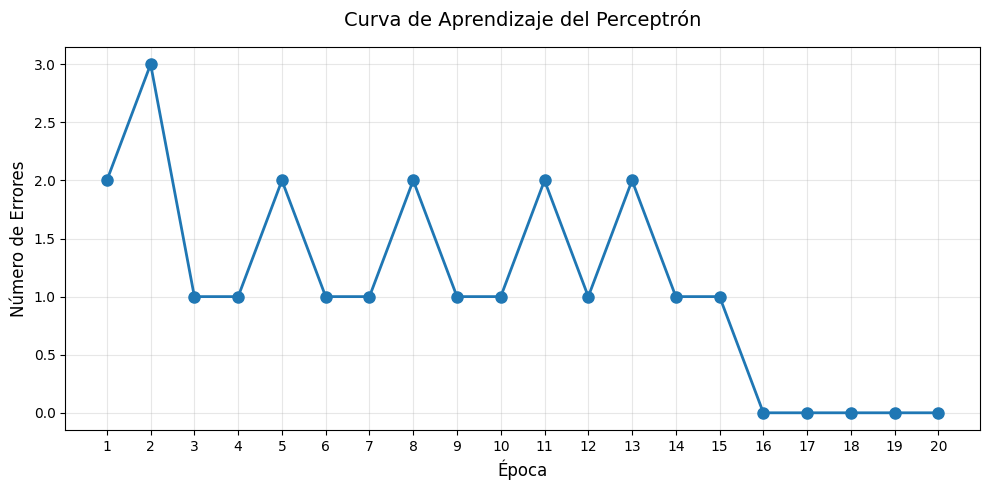

Interpretación de la curva:
- Una curva descendente indica que el modelo está aprendiendo
- Si llega a 0, el modelo convergió (clasifica perfectamente el training set)
- Si oscila sin bajar, el problema podría no ser linealmente separable


In [9]:
# Gráfico de errores por época
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(historial) + 1), historial, marker='o', linewidth=2, markersize=8)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Número de Errores', fontsize=12)
plt.title('Curva de Aprendizaje del Perceptrón', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(historial) + 1))
plt.tight_layout()
plt.show()

print("Interpretación de la curva:")
print("- Una curva descendente indica que el modelo está aprendiendo")
print("- Si llega a 0, el modelo convergió (clasifica perfectamente el training set)")
print("- Si oscila sin bajar, el problema podría no ser linealmente separable")

---

## 10. Análisis de Pesos Aprendidos

Inspeccionamos los pesos finales para entender qué aprendió el modelo.

In [10]:
print("Pesos aprendidos por el perceptrón:")
print("=" * 70)

# Ordenamos palabras por peso (de más positivo a más negativo)
indices_ordenados = np.argsort(pesos_entrenados)[::-1]

print("\nPalabras ordenadas por influencia (de más positiva a más negativa):\n")
for idx in indices_ordenados:
    palabra = vocabulario[idx]
    peso = pesos_entrenados[idx]
    if peso > 0:
        influencia = "POSITIVA"
    elif peso < 0:
        influencia = "NEGATIVA"
    else:
        influencia = "NEUTRA"

    print(f"  {palabra:15s} → peso = {peso:7.4f}  [{influencia}]")

print(f"\nBias (sesgo): {bias_entrenado:.4f}")

print("\n" + "=" * 70)
print("Interpretación:")
print("- Pesos positivos: Palabras asociadas con sentimiento positivo")
print("- Pesos negativos: Palabras asociadas con sentimiento negativo")
print("- Magnitud del peso: Importancia de la palabra en la decisión")

Pesos aprendidos por el perceptrón:

Palabras ordenadas por influencia (de más positiva a más negativa):

  encanta         → peso =  0.3142  [POSITIVA]
  gusta           → peso = -0.2580  [NEGATIVA]
  amo             → peso = -0.2634  [NEGATIVA]
  espectacular    → peso = -0.3249  [NEGATIVA]
  asado           → peso = -0.5133  [NEGATIVA]
  bajón           → peso = -0.5623  [NEGATIVA]
  detesto         → peso = -0.9080  [NEGATIVA]
  no              → peso = -0.9657  [NEGATIVA]
  perdí           → peso = -1.1128  [NEGATIVA]
  calor           → peso = -1.4123  [NEGATIVA]

Bias (sesgo): 1.0000

Interpretación:
- Pesos positivos: Palabras asociadas con sentimiento positivo
- Pesos negativos: Palabras asociadas con sentimiento negativo
- Magnitud del peso: Importancia de la palabra en la decisión


---

## 11. Evaluación del Modelo Entrenado

Probamos el perceptrón entrenado con el conjunto de entrenamiento.

In [11]:
print("Evaluación en el conjunto de entrenamiento:")
print("=" * 70)

aciertos = 0

for i in range(len(frases)):
    x_i = X[i]
    y_real = etiquetas[i]
    y_pred = predecir(x_i, pesos_entrenados, bias_entrenado)

    correcto = "✓" if y_pred == y_real else "✗"
    if y_pred == y_real:
        aciertos += 1

    sentimiento_real = "Positivo" if y_real == 1 else "Negativo"
    sentimiento_pred = "Positivo" if y_pred == 1 else "Negativo"

    print(f"\n{correcto} Frase: '{frases[i]}'")
    print(f"  Real: {sentimiento_real} | Predicción: {sentimiento_pred}")

accuracy = aciertos / len(frases)
print("\n" + "=" * 70)
print(f"Accuracy: {aciertos}/{len(frases)} = {accuracy:.2%}")

Evaluación en el conjunto de entrenamiento:

✓ Frase: 'Amo el verano en Buenos Aires'
  Real: Positivo | Predicción: Positivo

✓ Frase: 'No me gusta el tráfico matutino'
  Real: Negativo | Predicción: Negativo

✓ Frase: 'Este asado está espectacular'
  Real: Positivo | Predicción: Positivo

✓ Frase: 'Qué bajón, perdí el colectivo'
  Real: Negativo | Predicción: Negativo

✓ Frase: 'Me encanta salir los domingos'
  Real: Positivo | Predicción: Positivo

✓ Frase: 'Detesto el calor húmedo'
  Real: Negativo | Predicción: Negativo

Accuracy: 6/6 = 100.00%


---

## 12. Predicción sobre Frases Nuevas

Ahora probamos el perceptrón con frases que nunca vio durante el entrenamiento.

In [12]:
# Frases nuevas para testear
frases_prueba = [
    "No aguanto este calor",
    "Qué hermoso día para pasear",
    "Detesto levantarme temprano",
    "Me encanta el asado del domingo",
    "Qué bajón el tráfico de hoy"
]

print("Predicciones sobre frases nuevas:")
print("=" * 70)

for frase in frases_prueba:
    # Vectorizamos la frase
    x_test = vectorizar(frase, vocabulario)

    # Hacemos la predicción
    prediccion = predecir(x_test, pesos_entrenados, bias_entrenado)

    # Calculamos la suma ponderada para ver la confianza
    z = np.dot(pesos_entrenados, x_test) + bias_entrenado

    sentimiento = "POSITIVO" if prediccion == 1 else "NEGATIVO"

    print(f"\nFrase: '{frase}'")
    print(f"Predicción: {sentimiento}")
    print(f"Suma ponderada (z): {z:.4f}")
    print(f"Palabras detectadas: {[vocabulario[i] for i in range(len(vocabulario)) if x_test[i] == 1]}")

Predicciones sobre frases nuevas:

Frase: 'No aguanto este calor'
Predicción: NEGATIVO
Suma ponderada (z): -1.3780
Palabras detectadas: ['no', 'calor']

Frase: 'Qué hermoso día para pasear'
Predicción: POSITIVO
Suma ponderada (z): 1.0000
Palabras detectadas: []

Frase: 'Detesto levantarme temprano'
Predicción: POSITIVO
Suma ponderada (z): 0.0920
Palabras detectadas: ['detesto']

Frase: 'Me encanta el asado del domingo'
Predicción: POSITIVO
Suma ponderada (z): 0.8010
Palabras detectadas: ['asado', 'encanta']

Frase: 'Qué bajón el tráfico de hoy'
Predicción: POSITIVO
Suma ponderada (z): 0.4377
Palabras detectadas: ['bajón']


---

## 13. Limitaciones del Perceptrón Simple

El perceptrón tiene restricciones importantes que debemos entender.

In [ ]:
print("LIMITACIONES DEL PERCEPTRÓN SIMPLE")
print("=" * 70)

print("\n1. SOLO PROBLEMAS LINEALMENTE SEPARABLES")
print("-" * 70)
print("El perceptrón solo puede aprender patrones que se pueden separar con")
print("una línea recta (en 2D) o un hiperplano (en >2D).")
print("\nEjemplo clásico: No puede resolver XOR (Minsky & Papert, 1969)")
print("\nXOR:  A  B  | Salida")
print("      0  0  |   0")
print("      0  1  |   1")
print("      1  0  |   1")
print("      1  1  |   0")
print("\nNo existe una línea recta que separe correctamente estos 4 puntos.")

print("\n2. IGNORA EL ORDEN DE LAS PALABRAS")
print("-" * 70)
print("Bag of Words trata 'No me gusta' igual que 'Me gusta, no'")
print("El modelo no captura negaciones ni contexto.")

print("\n3. NO CAPTURA RELACIONES COMPLEJAS")
print("-" * 70)
print("Solo aprende combinaciones lineales de features.")
print("No puede modelar interacciones entre palabras (ej: 'no muy bueno').")

print("\n4. FUNCIÓN DE ACTIVACIÓN NO DIFERENCIABLE")
print("-" * 70)
print("La función escalón no tiene derivada en z=0.")
print("Esto impide usar backpropagation para redes multicapa.")

print("\n5. SENSIBLE A OUTLIERS Y RUIDO")
print("-" * 70)
print("Un solo ejemplo mal etiquetado puede impedir convergencia.")

print("\n" + "=" * 70)
print("SOLUCIÓN: Redes Neuronales Multicapa (MLP)")
print("=" * 70)
print("Agregar capas ocultas permite:")
print("- Resolver problemas no linealmente separables (como XOR)")
print("- Aprender representaciones jerárquicas")
print("- Capturar interacciones complejas entre features")
print("\nEsto lo veremos en el próximo notebook con PyTorch.")

---

## Guía Teórico-Conceptual

### 1. Historia y Contexto del Perceptrón

**1943**: McCulloch y Pitts proponen el primer modelo matemático de neurona

**1958**: Frank Rosenblatt construye el Mark I Perceptron en Cornell, una computadora analógica que podía aprender a reconocer patrones visuales

**1960s**: Optimismo inicial. Se pensaba que los perceptrones podrían resolver cualquier problema de reconocimiento de patrones

**1969**: Minsky y Papert publican "Perceptrons", demostrando matemáticamente sus limitaciones (no puede resolver XOR ni problemas no lineales). Esto causó el primer "invierno de la IA"

**1986**: Rumelhart, Hinton y Williams popularizaron backpropagation, permitiendo entrenar redes multicapa y superar las limitaciones del perceptrón simple

**Hoy**: El perceptrón es el building block de redes con millones de neuronas (BERT tiene 110M de parámetros)

### 2. Fundamentos Matemáticos

**Producto punto como similitud:**

El producto punto $w \cdot x$ mide la similitud entre el vector de pesos y el vector de entrada:
- Si son similares (apuntan en la misma dirección): producto alto
- Si son opuestos: producto bajo o negativo
- Si son ortogonales: producto cero

**Interpretación geométrica:**

El perceptrón define un hiperplano en el espacio de features:
$$w_1 x_1 + w_2 x_2 + ... + w_n x_n + b = 0$$

- Un lado del hiperplano: clase 1
- Otro lado: clase 0
- El vector w es perpendicular al hiperplano
- El bias b desplaza el hiperplano del origen

**Convergencia:**

Teorema de convergencia del perceptrón (Rosenblatt, 1958):
> Si los datos son linealmente separables, el algoritmo del perceptrón converge en un número finito de pasos.

Pero: No hay garantía sobre cuántas iteraciones necesitará.

### 3. Relación con Descenso de Gradiente

La regla de actualización del perceptrón es un caso especial de descenso de gradiente:

**Descenso de gradiente general:**
$$w_{nuevo} = w_{viejo} - \alpha \frac{\partial L}{\partial w}$$

**Perceptrón:**
$$w_{nuevo} = w_{viejo} + \alpha \cdot error \cdot x$$

El perceptrón actualiza pesos solo cuando hay error (gradiente implícito de 0 cuando no hay error).

### 4. Comparación: Perceptrón vs. Regresión Logística

| Característica | Perceptrón | Regresión Logística |
|----------------|------------|---------------------|
| Función de activación | Escalón | Sigmoide |
| Salida | Binaria (0 o 1) | Probabilidad (0 a 1) |
| Diferenciable | No | Sí |
| Función de pérdida | Errores de clasificación | Cross-entropy |
| Actualización | Solo cuando hay error | Siempre (proporcional al gradiente) |
| Convergencia | Garantizada si linealmente separable | Siempre converge (convexo) |
| Interpretación | Clasificador duro | Clasificador probabilístico |

### 5. Problema XOR: El Límite de la Linealidad

XOR (OR exclusivo) es el ejemplo clásico de problema no linealmente separable:

```
Entrada (x₁, x₂)  | Salida
(0, 0)            | 0
(0, 1)            | 1  
(1, 0)            | 1
(1, 1)            | 0
```

Si graficamos en 2D:
```
  x₂
  |
1 | 1   0    ← No hay línea recta que separe
  |           los 1s de los 0s
0 | 0   1
  +--------- x₁
    0   1
```

**Solución:** Red multicapa (MLP) con una capa oculta puede resolver XOR al proyectar los datos a un espacio de mayor dimensión donde SÍ son linealmente separables.

### 6. Tasa de Aprendizaje: Finding the Sweet Spot

El hiperparámetro α (learning rate) controla cuánto ajustamos los pesos en cada paso:

**α muy pequeño (ej: 0.001):**
- Pro: Actualizaciones suaves, convergencia estable
- Contra: Aprendizaje muy lento, muchas épocas necesarias

**α muy grande (ej: 10):**
- Pro: Aprendizaje rápido inicialmente
- Contra: Puede oscilar sin converger, inestabilidad

**α óptimo (ej: 0.1 - 0.5):**
- Balance entre velocidad y estabilidad
- Depende del problema y la escala de los datos

**Estrategias modernas:**
- Learning rate decay: Empezar alto y reducir gradualmente
- Optimizadores adaptativos (Adam, RMSprop): Ajustan α automáticamente

### 7. Del Perceptrón al Deep Learning

El camino evolutivo:

1. **Perceptrón simple** (1958): Una neurona, función escalón
2. **Adaline** (1960): Una neurona, función lineal, descenso de gradiente
3. **MLP (Perceptrón Multicapa)** (1986): Múltiples capas, backpropagation
4. **Redes Convolucionales (CNN)** (1998): Para imágenes, LeCun
5. **Redes Recurrentes (RNN/LSTM)** (1997): Para secuencias temporales
6. **Transformers** (2017): Attention, BERT, GPT

**Elemento común:** Todos usan variaciones de la regla básica w = w + Δw que vimos en el perceptrón.

---

## Preguntas y Respuestas para Estudio

### Preguntas Conceptuales

**1. ¿Por qué se dice que el perceptrón es un "clasificador lineal"?**

*Respuesta:* Porque la frontera de decisión que aprende es lineal (una línea en 2D, un hiperplano en dimensiones superiores). La ecuación $w_1x_1 + w_2x_2 + ... + w_nx_n + b = 0$ define un hiperplano que separa las dos clases. Todo lo que esté de un lado se clasifica como 1, del otro como 0.

**2. ¿Qué significa "linealmente separable"?**

*Respuesta:* Un conjunto de datos es linealmente separable si existe un hiperplano que puede seperar perfectamente las dos clases. Por ejemplo, en 2D significa que podemos dibujar una línea recta que deje todos los puntos de una clase a un lado y todos los de la otra clase al otro lado.

**3. ¿Por qué el perceptrón no puede resolver XOR?**

*Respuesta:* Porque XOR no es linealmente separable. Si graficamos los 4 puntos de XOR en 2D, no existe ninguna línea recta que separe correctamente los 1s de los 0s. Necesitaríamos una frontera de decisión curva o quebrada, lo cual requiere una red multicapa.

**4. ¿Cuál es la diferencia entre una época y una iteración?**

*Respuesta:*
- **Iteración**: Una actualización de pesos (procesar una muestra o un batch)
- **Época**: Una pasada completa por todo el dataset de entrenamiento

Si tenemos 100 muestras y procesamos una a la vez, una época = 100 iteraciones.

**5. ¿Por qué inicializamos los pesos aleatoriamente y no en cero?**

*Respuesta:* Si todos los pesos empiezan en cero (o el mismo valor), todas las neuronas aprenderán lo mismo (simetría). La inicialización aleatoria rompe esta simetría, permitiendo que cada neurona especialice en features diferentes. En redes multicapa esto es crítico.

### Preguntas Técnicas

**6. En la regla de actualización w = w + α × error × x, ¿qué pasa si error = 0?**

*Respuesta:* No se actualizan los pesos (w = w + 0 = w). Esto es eficiente: solo ajustamos cuando el modelo se equivoca. En contraste, algoritmos como gradient descent actualizan pesos en cada iteración, incluso cuando la predicción es correcta.

**7. ¿Por qué multiplicamos por x_i en la actualización de pesos?**

*Respuesta:* Es la regla de Hebbian: "neuronas que disparan juntas, se conectan juntas". Si x_i es grande (la feature está presente) y hay error, queremos ajustar mucho ese peso porque esa feature es relevante. Si x_i = 0 (feature ausente), ese peso no se actualiza porque no influyó en la predicción.

**8. ¿Qué representa el bias (sesgo) geométricamente?**

*Respuesta:* El bias desplaza el hiperplano de decisión desde el origen. Sin bias, el hiperplano siempre pasa por (0,0,...,0). El bias permite mover el hiperplano para ajustarse mejor a los datos. Es equivalente a agregar una feature constante = 1.

**9. Si el historial de errores oscila sin bajar, ¿qué podría estar pasando?**

*Respuesta:* Tres posibilidades:
1. **Problema no linealmente separable**: No existe solución perfecta
2. **Learning rate muy alto**: Oscila alrededor del mínimo sin converger
3. **Ruido en los datos**: Ejemplos contradictorios o mal etiquetados

**10. ¿Por qué np.dot(w, x) y no un bucle for?**

*Respuesta:* El producto punto está altamente optimizado en NumPy (usa BLAS, instrucciones SIMD). Es 100-1000x más rápido que un bucle Python. Esta diferencia es crítica en deep learning donde hacemos millones de estas operaciones.

### Preguntas de Aplicación

**11. Si tuvieras un dataset con 3 clases (positivo, negativo, neutral), ¿podrías usar un perceptrón simple?**

*Respuesta:* No directamente. El perceptrón simple es binario. Soluciones:
1. **One-vs-Rest**: Entrenar 3 perceptrones (positivo vs resto, negativo vs resto, neutral vs resto)
2. **Softmax**: Usar una red con múltiples salidas y función softmax (generalización del perceptrón)
3. **Descomposición binaria**: Positivo vs no-positivo, luego negativo vs neutral

**12. ¿En qué casos un perceptrón simple podría ser preferible a una red neuronal profunda?**

*Respuesta:*
- Dataset muy pequeño (< 100 muestras)
- Problema conocidamente lineal
- Necesidad de interpretabilidad extrema (pesos son directamente interpretables)
- Recursos computacionales MUY limitados
- Como baseline rápido antes de modelos complejos

**13. Si el modelo converge en la época 5 pero seguís entrenando 15 épocas más, ¿qué puede pasar?**

*Respuesta:* Con el perceptrón simple, no pasa nada malo. Una vez que error = 0, los pesos dejan de actualizarse. Sin embargo, en redes más complejas, entrenar de más puede causar overfitting. Es buena práctica usar "early stopping": detener cuando la validación deja de mejorar.

**14. ¿Cómo adaptarías este código para procesar el dataset amazon_cells_labelled.txt del Notebook 1?**

*Respuesta:*
```python
# 1. Cargar datos
df = pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=['review', 'sentiment'])

# 2. Construir vocabulario automáticamente
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, max_features=50)
X = vectorizer.fit_transform(df['review']).toarray()
y = df['sentiment'].values

# 3. Entrenar (el código del perceptrón es el mismo)
```

**15. Explicá por qué Bag of Words binario pierde información. ¿Qué alternativas hay?**

*Respuesta:* Bag of Words binario solo indica presencia/ausencia, ignorando:
1. **Frecuencia**: "muy muy bueno" se representa igual que "muy bueno"
2. **Orden**: "no me gusta" = "me gusta no"
3. **Contexto**: No captura bi-gramas ni tri-gramas

**Alternativas:**
- **Conteos**: [1, 2, 0, 1] en vez de binario
- **TF-IDF**: Ponderar por importancia en el corpus
- **N-gramas**: Incluir pares/triples de palabras
- **Embeddings**: Word2Vec, GloVe, BERT (representaciones densas)

---

## Ejercicios Propuestos

### Ejercicio 1: Experimentación con Learning Rate
Entrená el perceptrón con diferentes tasas de aprendizaje: 0.01, 0.1, 0.5, 1.0, 5.0. Graficá las curvas de aprendizaje. ¿Cuál converge más rápido? ¿Alguna no converge?

### Ejercicio 2: Dataset Aumentado
Agregá 10 frases más al corpus (5 positivas, 5 negativas). Re-entrená y compará:
- ¿Converge en menos épocas?
- ¿Los pesos cambián significativamente?
- ¿Mejora la generalización?

### Ejercicio 3: Visualización de la Frontera de Decisión
Si tu vocabulario tiene solo 2 palabras, podés graficar la frontera de decisión en 2D:
```python
# Pseudo-código
x1 = np.linspace(0, 1, 100)
x2 = -(w[0]*x1 + bias) / w[1]  # Despejar de w1*x1 + w2*x2 + b = 0
plt.plot(x1, x2)  # Línea de decisión
plt.scatter(X[:, 0], X[:, 1], c=y)  # Puntos de datos
```
Implementalo con un vocabulario reducido.

### Ejercicio 4: Problema XOR
Intentá entrenar el perceptrón con el problema XOR:
```python
X_xor = np.array([[0,0], [0,1], [1,0], [1,1]])
y_xor = np.array([0, 1, 1, 0])
```
Observá que no converge. Graficá la frontera de decisión y los puntos para visualizar por qué.

### Ejercicio 5: Implementar Regresión Logística desde Cero
Modificá el código para usar función sigmoide en vez de escalón:
```python
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
```
Cambiar la regla de actualización a:
```python
error = y_real - sigmoid(z)  # Error continuo
```
Compará con el perceptrón original.

---

## Conclusión

En este notebook construimos desde cero el modelo fundamental de las redes neuronales. Aprendimos:

1. **Arquitectura de una neurona artificial**: Pesos, bias, suma ponderada, función de activación
2. **Regla de aprendizaje**: Ajuste de pesos basado en errores
3. **Implementación manual**: Todo con NumPy, sin frameworks
4. **Limitaciones fundamentales**: Problemas linealmente separables, XOR, función no diferenciable
5. **Intuición sobre descenso de gradiente**: Base conceptual para backpropagation

### ¿Qué sigue?

Las limitaciones del perceptrón motivaron el desarrollo de **redes multicapa** (MLP). En el próximo notebook vamos a:
- Usar PyTorch para construir una red con capas ocultas
- Resolver problemas no lineales
- Usar funciones de activación diferenciables (ReLU, Sigmoid)
- Aprovechar backpropagation automática

Pero ahora ya entendés qué hace PyTorch por debajo: multiplicaciones matriciales, actualizaciones de pesos y funciones no lineales. No es magia, es matemática que acabás de implementar vos mismo.

---

*Este material fue desarrollado con fines educativos para la Tecnicatura en Ciencia de Datos del IFTS.*